In [ ]:
import pandas as pd
import numpy as np

df = pd.read_parquet('../data/full_imputed_n_index.parquet')
# 1. Identify all INDEX_ columns except the target
index_cols = [
    col for col in df.columns 
    if col.startswith('INDEX_') and col != 'INDEX_v2x_corr'
]

# 2. Drop those columns (this keeps INDEX_v2x_corr)
df = df.drop(columns=index_cols)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV, LassoCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 1. Prepare data, drop missing target ---
df_model = df.copy().dropna(subset=['INDEX_v2x_corr'])
y = df_model['INDEX_v2x_corr']
X = df_model.drop(columns=['INDEX_v2x_corr'])

# --- 2. Train/test split (same split for all models) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# --- 3. Ridge & Lasso pipelines (auto impute + one-hot) ---
numeric_feats    = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = ['country_name']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer,   numeric_feats),
    ('cat', cat_transformer, categorical_feats)
])

# RidgeCV
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
pipe_ridge = Pipeline([
    ('preproc', preprocessor),
    ('ridge',   ridge)
])
pipe_ridge.fit(X_train, y_train)
pred_ridge = pipe_ridge.predict(X_test)

# LassoCV
lasso = LassoCV(cv=5, max_iter=10000)
pipe_lasso = Pipeline([
    ('preproc', preprocessor),
    ('lasso',   lasso)
])
pipe_lasso.fit(X_train, y_train)
pred_lasso = pipe_lasso.predict(X_test)

# --- 4. OLS via statsmodels (manual preproc) ---
# 4a. Numeric cols with data
valid_nums = [c for c in numeric_feats if df_model[c].notna().any()]

# 4b. Subset & one-hot
X_ols = X[valid_nums + categorical_feats].copy()
X_ols['country_name'] = X_ols['country_name'].fillna('missing')
X_ols = pd.get_dummies(X_ols, columns=['country_name'], drop_first=True)

# 4c. Impute numeric
imp = SimpleImputer(strategy='mean')
X_ols[valid_nums] = imp.fit_transform(X_ols[valid_nums])

# 4d. Drop any non-numeric
X_ols = X_ols.select_dtypes(include=[np.number])

# 4e. Split & fit
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    X_ols, y, test_size=0.20, random_state=42
)
ols_model = sm.OLS(y_train_o, sm.add_constant(X_train_o)).fit()
pred_ols   = ols_model.predict(sm.add_constant(X_test_o))

# --- 5. Compute metrics & assemble results ---
from sklearn.metrics import r2_score

results = pd.DataFrame({
    'Model':      ['OLS',     'Ridge',   'Lasso'],
    'Test MSE':   [
        mean_squared_error(y_test_o, pred_ols),
        mean_squared_error(y_test,   pred_ridge),
        mean_squared_error(y_test,   pred_lasso)
    ],
    'Test R²':    [
        r2_score(y_test_o, pred_ols),
        r2_score(y_test,   pred_ridge),
        r2_score(y_test,   pred_lasso)
    ],
    'Best α (if any)': [
        None,
        pipe_ridge.named_steps['ridge'].alpha_,
        pipe_lasso.named_steps['lasso'].alpha_
    ]
})

print(results)

# Optional: in‐sample R² for OLS
print(f"\nOLS in-sample R²: {ols_model.rsquared:.3f}")

# --- 6. Plot comparison ---
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Test R²'])
plt.title('Test Set R²: OLS vs Ridge vs Lasso')
plt.ylabel('R²')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


/Users/paulotto/Developer/hertieAssignments/mlPaper/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['v3pechilabl' 'v3ellovtlg' 'v3lglegllo' 'v3eltvriguc' 'v3elageuc'
 'v3stcitlaw' 'v3elsec' 'v3eldirelc' 'v3eldireuc' 'v3eldirepr'
 'v3elncbmaj' 'v3elupvtlg' 'v3elupvtsm' 'v3elupstsl' 'v3elupseat'
 'v3elupstsm' 'v3ttlvote' 'v3psagefirst' 'v3psagesecond' 'v3psagethird'
 'v3psagepm' 'v3elwomcab' 'v3elncbpr' 'v3elagepr' 'v3elvotsml'
 'v3elloelsy' 'v3elparlel' 'v3eltrnout' 'v3elloseat' 'v3ellostlg'
 'v3elvotlrg' 'v3ellovtsm' 'v3ellostsl' 'v3ellostsm' 'v3ellostss'
 'v3exagehos' 'v3eltvrig' 'v3expathhs' 'v3lgelecup' 'v3lginelup'
 'v3lgleglup' 'v3lgello' 'v3lginello' 'v3lgqumin' 'v3lgintblo' 'v3lgamend'
 'v3lgamnsty']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/paulotto/Developer/hertieAssignments/mlPaper/.venv/lib/python3.11/site-packages/sklearn/linear_model/_r

   Model  Test MSE   Test R²    Best α
0    OLS  0.010738  0.868308       NaN
1  Ridge  0.003625  0.955539  0.305386
2  Lasso  0.076984  0.055894  2.831639

OLS in-sample R²: 0.915


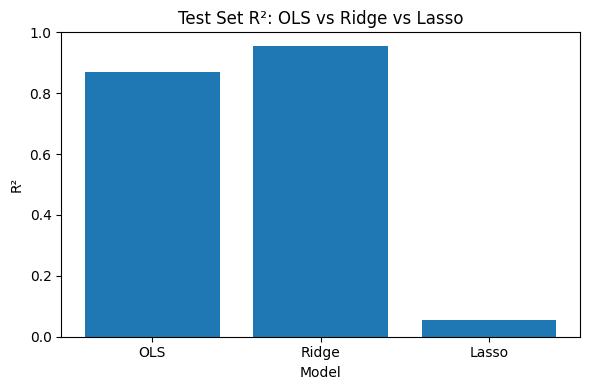

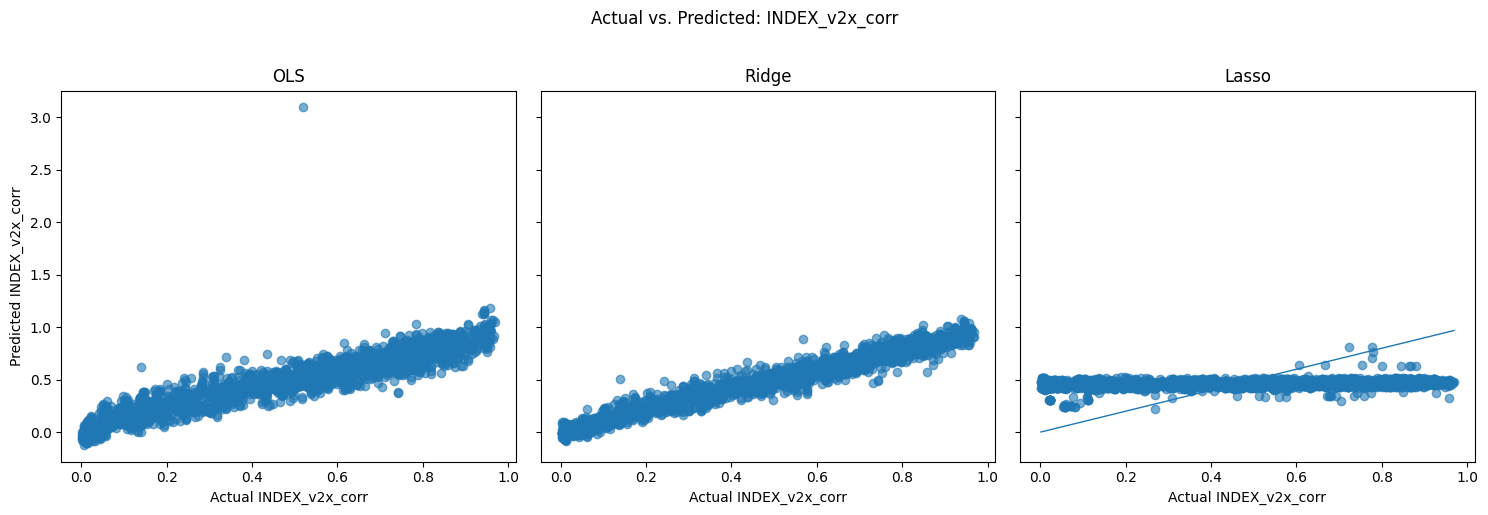

In [10]:
import pandas as pd
import numpy as np

# 0. Load and drop other INDEX_ columns
df = pd.read_parquet('../data/full_imputed_n_index.parquet')
index_cols = [col for col in df.columns 
              if col.startswith('INDEX_') and col != 'INDEX_v2x_corr']
df = df.drop(columns=index_cols)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV, LassoCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Prepare data, drop missing target
df_model = df.copy().dropna(subset=['INDEX_v2x_corr'])
y = df_model['INDEX_v2x_corr']
X = df_model.drop(columns=['INDEX_v2x_corr'])

# 2. Train/test split (same for all)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 3. Build sklearn preprocessor for Ridge/Lasso
numeric_feats     = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = ['country_name']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_transformer,   numeric_feats),
    ('cat', cat_transformer, categorical_feats)
])

# 4. RidgeCV
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
pipe_ridge = Pipeline([
    ('preproc', preprocessor),
    ('ridge',   ridge)
])
pipe_ridge.fit(X_train, y_train)
pred_ridge = pipe_ridge.predict(X_test)

# 5. LassoCV
lasso = LassoCV(cv=5, max_iter=10000)
pipe_lasso = Pipeline([
    ('preproc', preprocessor),
    ('lasso',   lasso)
])
pipe_lasso.fit(X_train, y_train)
pred_lasso = pipe_lasso.predict(X_test)

# 6. OLS via statsmodels (manual preproc)
valid_nums = [c for c in numeric_feats if df_model[c].notna().any()]

X_ols = X[valid_nums + categorical_feats].copy()
X_ols['country_name'] = X_ols['country_name'].fillna('missing')
X_ols = pd.get_dummies(X_ols, columns=['country_name'], drop_first=True)

imp = SimpleImputer(strategy='mean')
X_ols[valid_nums] = imp.fit_transform(X_ols[valid_nums])
X_ols = X_ols.select_dtypes(include=[np.number])

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    X_ols, y, test_size=0.20, random_state=42
)
ols_model = sm.OLS(y_train_o, sm.add_constant(X_train_o)).fit()
pred_ols   = ols_model.predict(sm.add_constant(X_test_o))

# 7. Metrics & results
results = pd.DataFrame({
    'Model':      ['OLS', 'Ridge', 'Lasso'],
    'Test MSE':   [
        mean_squared_error(y_test_o, pred_ols),
        mean_squared_error(y_test,   pred_ridge),
        mean_squared_error(y_test,   pred_lasso)
    ],
    'Test R²':    [
        r2_score(y_test_o, pred_ols),
        r2_score(y_test,   pred_ridge),
        r2_score(y_test,   pred_lasso)
    ],
    'Best α': [
        None,
        pipe_ridge.named_steps['ridge'].alpha_,
        pipe_lasso.named_steps['lasso'].alpha_
    ]
})
print(results)
print(f"\nOLS in-sample R²: {ols_model.rsquared:.3f}")

# 8. Plot Test R² comparison
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Test R²'])
plt.title('Test Set R²: OLS vs Ridge vs Lasso')
plt.ylabel('R²')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 9. Actual vs. Predicted scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# OLS
axes[0].scatter(y_test_o, pred_ols, alpha=0.6)
axes[0].plot([y_test_o.min(), y_test_o.max()],
             [y_test_o.min(), y_test_o.max()],
             linewidth=1)
axes[0].set_title('OLS')
axes[0].set_xlabel('Actual INDEX_v2x_corr')
axes[0].set_ylabel('Predicted INDEX_v2x_corr')

# Ridge
axes[1].scatter(y_test, pred_ridge, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             linewidth=1)
axes[1].set_title('Ridge')
axes[1].set_xlabel('Actual INDEX_v2x_corr')

# Lasso
axes[2].scatter(y_test, pred_lasso, alpha=0.6)
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             linewidth=1)
axes[2].set_title('Lasso')
axes[2].set_xlabel('Actual INDEX_v2x_corr')

plt.suptitle('Actual vs. Predicted: INDEX_v2x_corr', y=1.02)
plt.tight_layout()
plt.show()
